In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random as rd

In [4]:
#reading each xlsx and changing columns to match to then concat
df2014 = pd.read_excel('data/ttc-streetcar-delay-data-2014.xlsx')
df2015 = pd.read_excel('data/ttc-streetcar-delay-data-2015.xlsx')
df2016 = pd.read_excel('data/ttc-streetcar-delay-data-2016.xlsx')
df2017 = pd.read_excel('data/ttc-streetcar-delay-data-2017.xlsx')
df2018 = pd.read_excel('data/ttc-streetcar-delay-data-2018.xlsx')
df2019 = pd.read_excel('data/ttc-streetcar-delay-data-2019.xlsx')
df2020 = pd.read_excel('data/ttc-streetcar-delay-data-2020_final.xlsx').rename(columns={'Delay':'Min Delay',
                                                                                  'Gap':'Min Gap'})
df2021 = pd.read_excel('data/ttc-streetcar-delay-data-jan-2021-to-august-2021.xlsx').rename(columns={'Bound':'Direction',
                                                                                               'Date':'Report Date',
                                                                                               'Line':'Route'})

df2014['Time'] = pd.to_datetime(df2014['Time'], format='%H:%M:%S').dt.time
df2015['Time'] = pd.to_datetime(df2015['Time'], format='%H:%M:%S').dt.time
df2016['Time'] = pd.to_datetime(df2016['Time'], format='%H:%M:%S').dt.time
df2017['Time'] = pd.to_datetime(df2017['Time'], format='%H:%M:%S').dt.time
df2018['Time'] = pd.to_datetime(df2018['Time'], format='%H:%M:%S').dt.time
df2019['Time'] = pd.to_datetime(df2019['Time'], format='%H:%M:%S').dt.time
df2020['Time'] = pd.to_datetime(df2020['Time'], format='%H:%M:%S').dt.time
df2021['Time'] = pd.to_datetime(df2021['Time'], format='%H:%M:%S').dt.time

frames = [df2014, df2015, df2016, df2017, df2018, df2019, df2020, df2021]
df = pd.concat(frames)

In [4]:
df = df.rename(columns={'Report Date':'Report_Date','Min Delay':'Min_Delay','Min Gap':'Min_Gap',
                       'Round Time':'Round_Time'})

In [5]:
#summing na values
df.isna().sum()

Report_Date      0
Route            2
Time             0
Day              0
Location        21
Incident         0
Min_Delay        3
Min_Gap          5
Direction       98
Vehicle        503
Round_Time       0
dtype: int64

In [6]:
#removing vehicle as a column
df = df.drop('Vehicle', axis=1)

In [7]:
#removing na values
df = df.dropna()
df

,Report_Date,Route,Time,Day,Location,Incident,Min_Delay,Min_Gap,Direction,Round_Time
0,2014-01-02,505,06:31:00,Thursday,Dundas and Roncesvalles,Late Leaving Garage,4.0,8.0,E/B,06:30:00
1,2014-01-02,504,12:43:00,Thursday,King and Shaw,Utilized Off Route,20.0,22.0,E/B,12:30:00
2,2014-01-02,501,14:01:00,Thursday,Kingston road and Bingham,Held By,13.0,19.0,W/B,14:00:00
3,2014-01-02,504,14:22:00,Thursday,King St. and Roncesvalles Ave.,Investigation,7.0,11.0,W/B,14:30:00
4,2014-01-02,504,16:42:00,Thursday,King and Bathurst,Utilized Off Route,3.0,6.0,E/B,16:30:00
...,...,...,...,...,...,...,...,...,...,...
1012,2021-01-31,512,22:10:00,Sunday,GUNN'S LOOP,Mechanical,5.0,10.0,E,22:00:00
1013,2021-01-31,501,22:43:00,Sunday,QUEEN AND BROADVIEW,Emergency Services,11.0,21.0,W,22:30:00
1014,2021-01-31,504,00:15:00,Sunday,KING AND SPADINA,Mechanical,3.0,8.0,W,00:30:00
1016,2021-01-31,501,00:46:00,Sunday,QUEEN AND CHURCH,Held By,13.0,23.0,W,01:00:00


In [8]:
from datetime import timedelta

time_in_minutes = []
time_in_hours = []

for time in df['Time']:
    delta = timedelta(hours=int(time.strftime('%H')), 
                      minutes=int(time.strftime('%M')), 
                      seconds=int(time.strftime('%S')))
    total_seconds = delta.total_seconds()
    time_in_minutes.append(total_seconds/60)
    time_in_hours.append(total_seconds/60/60)
    
df['Time_in_minutes'] = time_in_minutes
df['Time_in_hours'] = time_in_hours

In [9]:
df_kmeans = df.drop(['Report_Date', 'Route', 'Time', 'Location', 'Incident', 'Min_Gap', 'Direction', 
                     'Round_Time', 'Time_in_minutes', 'Day'], axis=1)
df_kmeans

,Min_Delay,Time_in_hours
0,4.0,6.516667
1,20.0,12.716667
2,13.0,14.016667
3,7.0,14.366667
4,3.0,16.700000
...,...,...
1012,5.0,22.166667
1013,11.0,22.716667
1014,3.0,0.250000
1016,13.0,0.766667


In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Scale values from 0 to 1
df_scaled =  (df_kmeans - df_kmeans.min()) / (df_kmeans.max() - df_kmeans.min())
#it's important to scale the values otherwise you'll have some values that will take all the importance.

# Try various values of k
sil_scores = []
for k in range(10,20):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(df_scaled)
    label = clusterer.predict(df_scaled)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(df_scaled, label), 'label':label})
    # applying k means and saving the values to a list

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label'] #k value (idxmax()) that maximizes the silhouette score
best_label

# Present some summary statistics for each clusters
df_kmeans.groupby(best_label).mean()

,Min_Delay,Time_in_hours
0,9.540431,11.515004
1,8.045640,5.766882
2,12.532775,20.293910
3,8.829932,15.703596
4,14.704698,1.511298
5,455.111111,12.805556
6,8.878049,9.346023
7,11.525205,17.984682
8,13.169291,22.760400
9,11.762006,13.723390


In [11]:
df_kmeans.groupby(best_label).describe()

Min_Delay                                                             \
       count        mean        std    min     25%    50%    75%    max   
0      742.0    9.540431  12.357926    0.0    5.00    6.0   10.0  155.0   
1     1468.0    8.045640   8.256618    0.0    4.00    6.0    9.0   75.0   
2      717.0   12.532775  16.041604    0.0    5.00    7.0   12.0  152.0   
3     1029.0    8.829932  11.296811    0.0    4.00    6.0    9.0  175.0   
4      447.0   14.704698  15.383806    0.0    7.00   10.0   15.0  127.0   
5        9.0  455.111111  88.571221  313.0  418.00  458.0  502.0  600.0   
6      943.0    8.878049  10.009919    0.0    5.00    6.0    9.0   92.0   
7      853.0   11.525205  16.991323    0.0    5.00    6.0   10.0  161.0   
8      508.0   13.169291  22.880077    0.0    6.00    8.0   10.0  284.0   
9      937.0   11.762006  17.673799    0.0    5.00    6.0   10.0  177.0   
10    1264.0    7.174842   7.314470    0.0    4.00    5.0    8.0   74.0   
11      40.0  141.575000  59.191513   80.0   99.25  125.5  174.0  292.0   

   Time_in_hours                                                        \
           count       mean       std        min        25%        50%   
0          742.0  11.515004  0.618368  10.433333  11.033333  11.533333   
1         1468.0   5.766882  0.555164   3.633333   5.450000   5.850000   
2          717.0  20.293910  0.707818  19.150000  19.633333  20.283333   
3         1029.0  15.703596  0.591704  14.700000  15.200000  15.683333   
4          447.0   1.511298  0.930862   0.000000   0.716667   1.416667   
5            9.0  12.805556  4.982093   5.333333   9.683333  14.650000   
6          943.0   9.346023  0.574981   8.350000   8.866667   9.333333   
7          853.0  17.984682  0.656195  16.750000  17.416667  18.000000   
8          508.0  22.760400  0.696653  21.550000  22.116667  22.816667   
9          937.0  13.723390  0.595253  12.600000  13.216667  13.750000   
10        1264.0   7.411617  0.507236   6.600000   6.966667   7.366667   
11          40.0   6.123333  2.073276   1.350000   5.379167   6.041667   

                          
          75%        max  
0   12.033333  12.600000  
1    6.166667   6.583333  
2   20.933333  21.533333  
3   16.166667  16.850000  
4    2.233333   3.566667  
5   16.683333  18.800000  
6    9.825000  10.416667  
7   18.533333  19.150000  
8   23.333333  23.983333  
9   14.216667  14.766667  
10   7.833333   8.366667  
11   6.900000  10.716667

In [12]:
sil_scores

,k,silhouette_score,label
0,10,0.486440,"[5, 3, 9, 9, 1, 1, 1, 6, 4, 5, 5, 5, 5, 5, 5, ..."
1,11,0.479989,"[3, 10, 10, 10, 4, 8, 8, 1, 5, 3, 3, 3, 3, 3, ..."
2,12,0.488284,"[1, 9, 9, 9, 3, 7, 7, 2, 4, 1, 1, 1, 1, 1, 1, ..."
3,13,0.482479,"[5, 11, 11, 11, 2, 2, 7, 7, 3, 5, 5, 5, 5, 5, ..."
4,14,0.488259,"[1, 6, 6, 6, 13, 13, 5, 5, 4, 1, 1, 1, 1, 1, 1..."
5,15,0.465301,"[1, 7, 2, 2, 5, 5, 11, 11, 3, 9, 9, 9, 9, 9, 9..."
6,16,0.461216,"[9, 3, 11, 11, 6, 6, 13, 13, 5, 1, 1, 1, 1, 1,..."
7,17,0.459168,"[11, 12, 12, 5, 9, 1, 1, 1, 6, 3, 3, 3, 3, 3, ..."
8,18,0.454160,"[17, 6, 3, 3, 1, 1, 16, 16, 4, 0, 0, 0, 0, 0, ..."
9,19,0.455463,"[8, 14, 2, 2, 16, 16, 0, 0, 3, 11, 11, 11, 11,..."


For k = 3 The average silhouette_score is : 0.574524419984279
For k = 4 The average silhouette_score is : 0.5101078891631344
For k = 5 The average silhouette_score is : 0.5491503996752435
For k = 6 The average silhouette_score is : 0.5390024413694505
For k = 7 The average silhouette_score is : 0.5202578340682918
For k = 8 The average silhouette_score is : 0.5253382177519754
For k = 9 The average silhouette_score is : 0.5016477024793772
For k = 10 The average silhouette_score is : 0.48745905048598326
For k = 11 The average silhouette_score is : 0.4818356086970768
For k = 12 The average silhouette_score is : 0.48760722537157525
For k = 13 The average silhouette_score is : 0.4946864529718119
For k = 14 The average silhouette_score is : 0.4827116795027649
For k = 15 The average silhouette_score is : 0.47779589656691823
For k = 16 The average silhouette_score is : 0.46835025790212664
For k = 17 The average silhouette_score is : 0.45500106976641225
For k = 18 The average silhouette_score is 

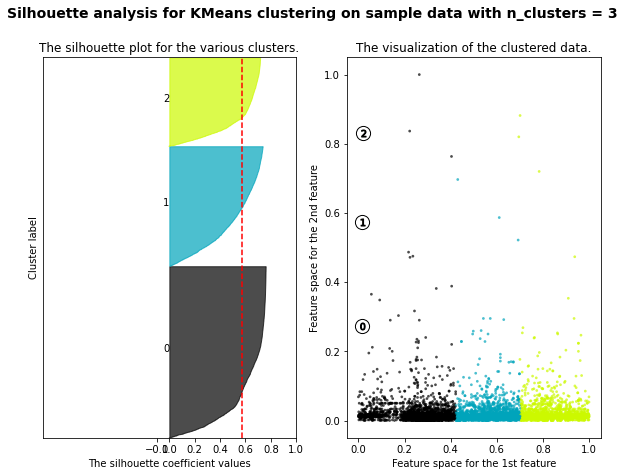

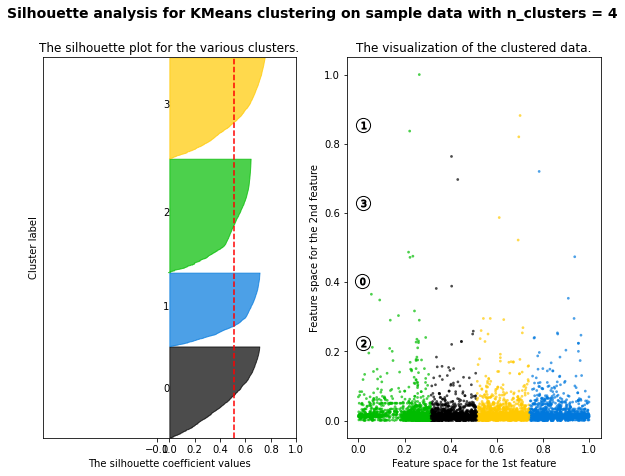

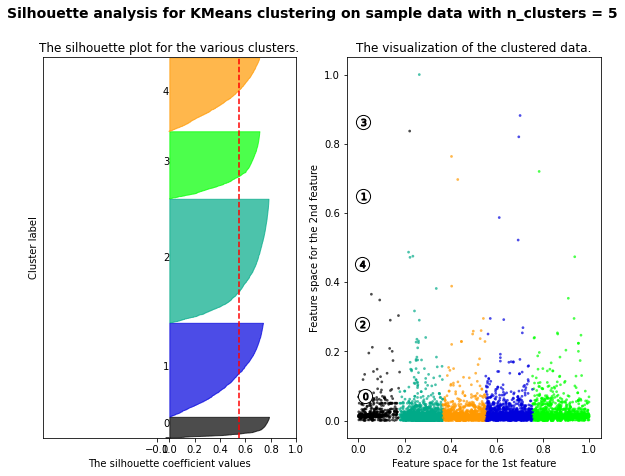

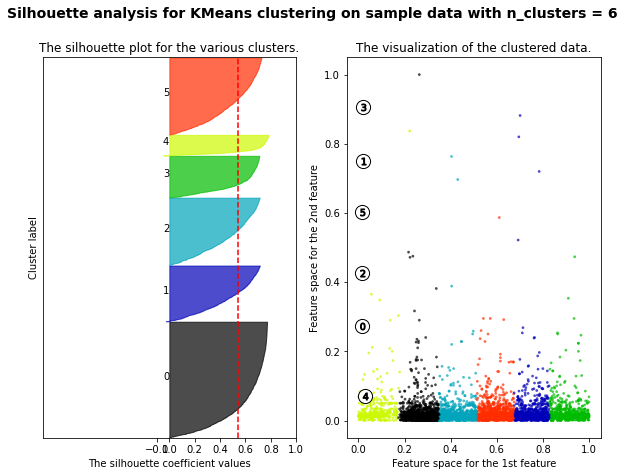

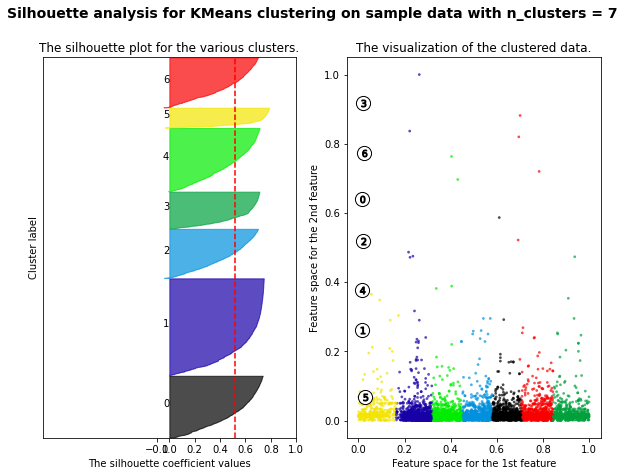

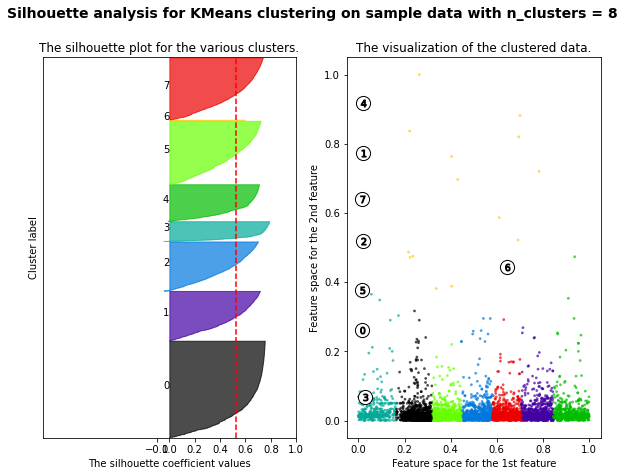

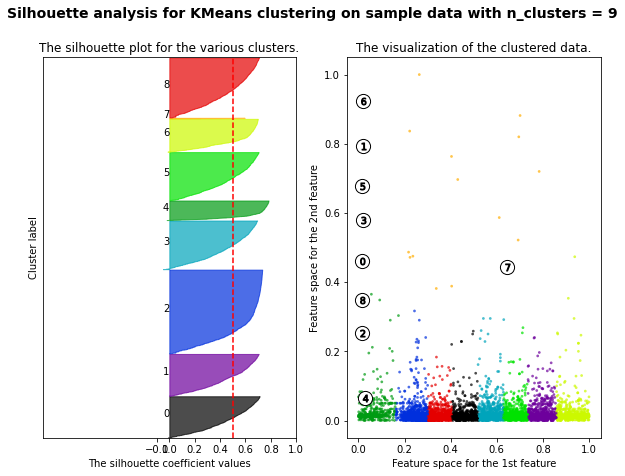

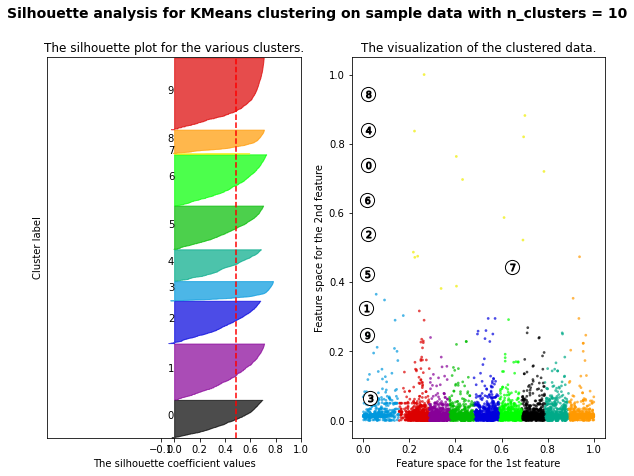

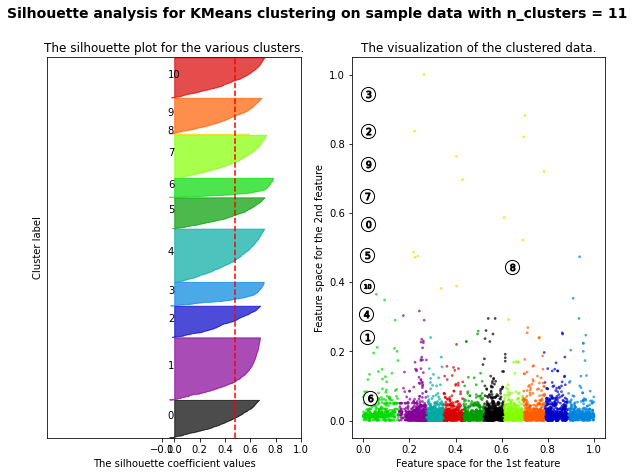

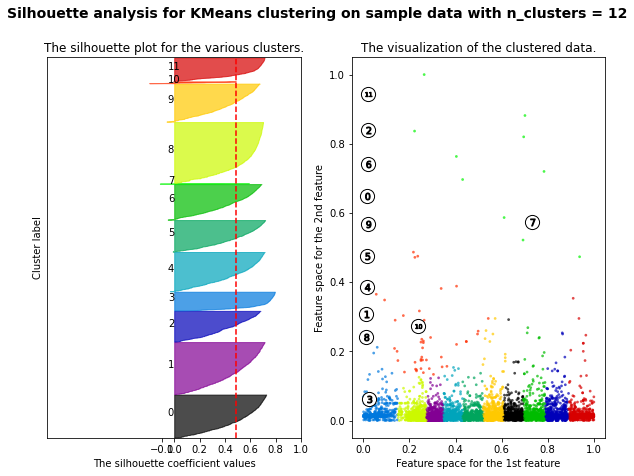

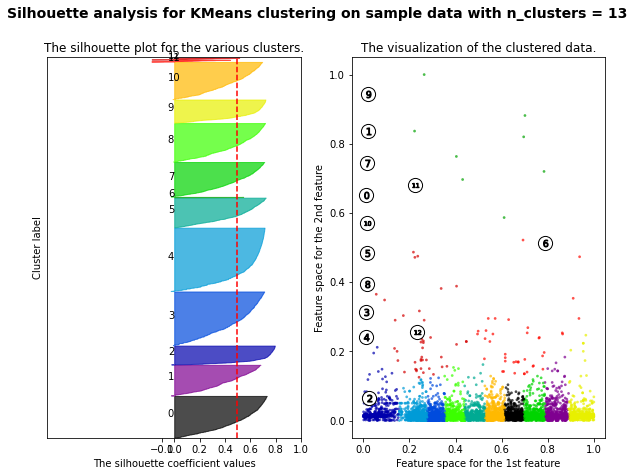

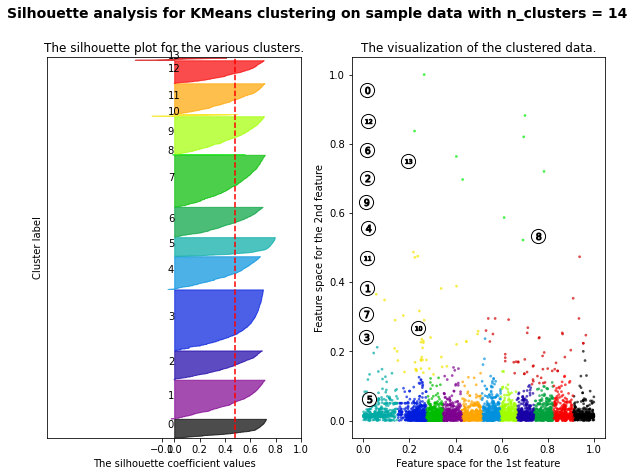

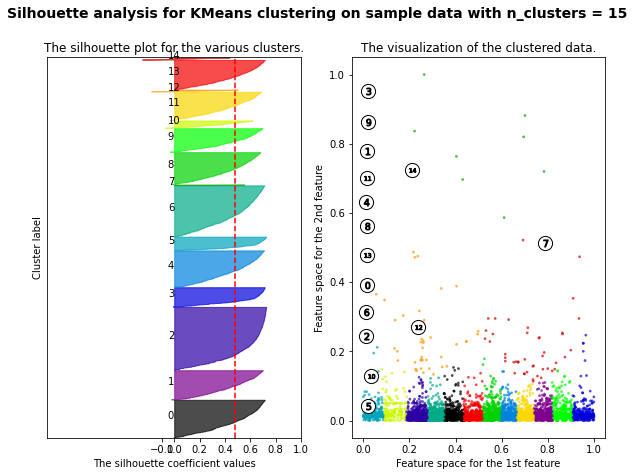

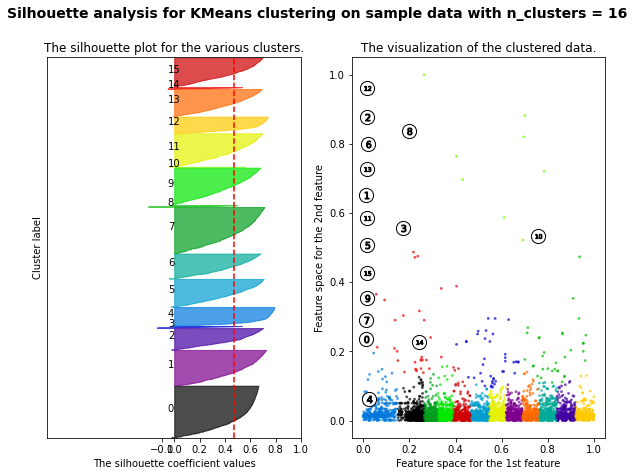

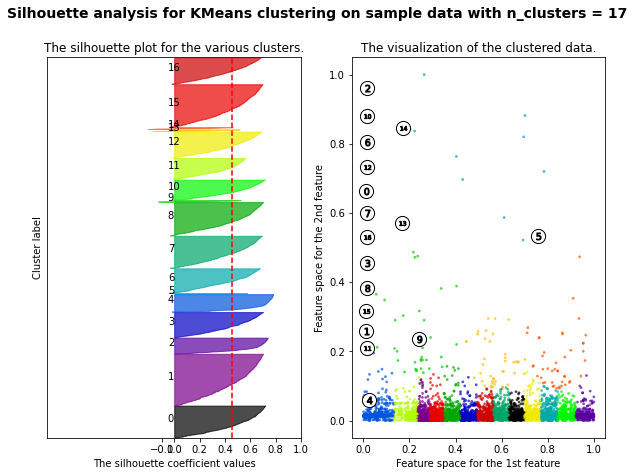

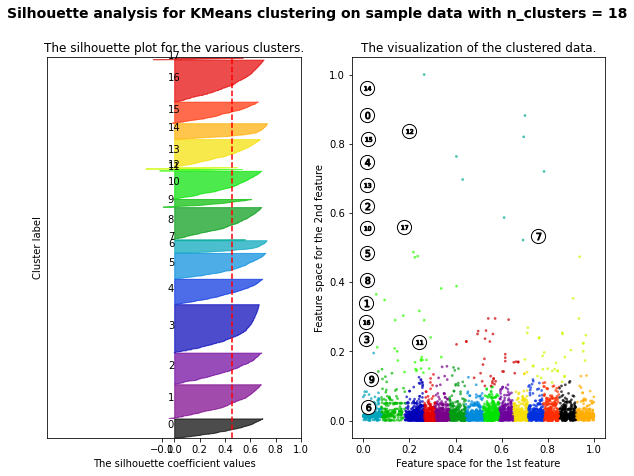

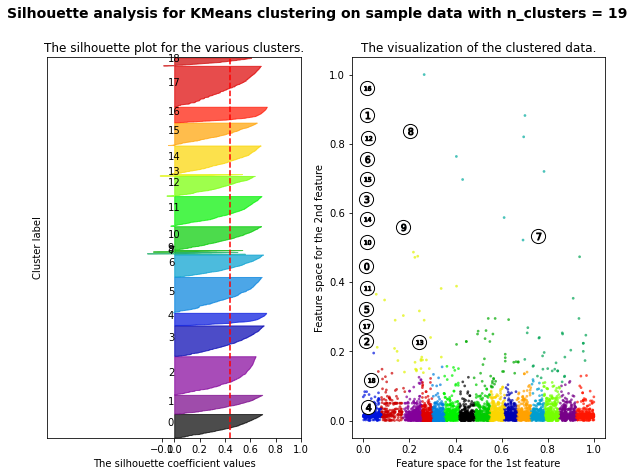

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

X, y = df_scaled['Time_in_hours'], df_scaled['Min_Delay']

for k in range(3,20):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(df_scaled)
    cluster_labels = clusterer.predict(df_scaled)
    
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(df_scaled, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        df_scaled['Time_in_hours'], df_scaled['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    